In [1]:
from PIL import Image
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sys
import os
from multiprocessing import Pool
from functools import partial
directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
from concurrent.futures import ProcessPoolExecutor, as_completed
from dask.distributed import Client, progress
from dask import compute, delayed
import dask.array as da
from dask.diagnostics import ProgressBar
plt.rcParams['figure.dpi']=400

# Problem 4.1

In [ ]:
def load_image(num):
    # loads image, converts to grayscale, then converts to a matrix
    image = Image.open('images/'+f'image{num}.png')
    gray_image = image.convert('L')
    matrix = np.array(gray_image)
    return matrix

def compute_svd(image_matrix):
    # computes the singular value decomposition of a matrix
    U, s, Vt = np.linalg.svd(image_matrix, full_matrices=False)
    return U, s, Vt

def compress_image(U, s, Vt, k):
    # compresses it to rank k
    S = np.diag(s[:k])
    return np.dot(U[:, :k], np.dot(S, Vt[:k, :]))

def frobenius_percent(original, approx):
    # computes frobenius error
    return 100*(np.linalg.norm(original - approx, 'fro')/np.linalg.norm(original, 'fro'))

def memory_saved(m, n, k, s):
    # computes percentage memory saved
    new = (m * k + k + n * k)
    old = m * len(s) + len(s) + n * len(s)
    return 100*(old-new)/old
    

In [ ]:
path = 2
A = load_image(path)
U, s, Vt = compute_svd(A)
N = int(np.log2(len(s)))
ks=[]

for i in range(2, N+1):
    ks.append(len(s)//2**i) 
    
images = [A]
titles = [f'Original, k = {len(s)}']
frobenius=[0]
m, n = A.shape
memory=[0]

for k in ks:
    A_k = compress_image(U, s, Vt, k)
    images.append(A_k)
    frobenius.append(frobenius_percent(A, A_k))
    memory.append(memory_saved(m, n, k, s))
    titles.append(f'k = {k}')

In [ ]:
num_images = len(images)
cols = min(num_images, 3)
rows = num_images // cols + (num_images % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(cols * (4*(m/n)), rows * 1.25*(n/m)))
fig.subplots_adjust(hspace=0, wspace=0)

axs = axs.ravel() if num_images > 1 else [axs]

for i in range(num_images):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(f'{titles[i]}\nFrobenius error: {frobenius[i]:.3g}%\nMemory saved: {memory[i]:.3g}%', fontsize=5)
    axs[i].axis('off')
for ax in axs[num_images:]:
    ax.axis('off')
plt.savefig(os.path.join(directory, 'compressed-milkyway.png'), dpi=400)
plt.show()

# Problem 4.2

In [39]:
def sparseH(L, J, h, periodic):
    
    """
    generates the sparse Hamiltonian matrix for the quantum Ising chain
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (csr_matrix): sparse matrix representing the Hamiltonian operator
    """
    
    dim = 2 ** L # dimensions of the Hilbert space
    
    # initialize 
    H_data = []
    H_rows = []
    H_cols = []
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1, L + 1): # iterate over all sites
            
            alpha = beta ^ (1 << (j - 1)) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            "Keep track of the indices with non-zero matrix elements"
            
            H_data.append(-h)
            H_rows.append(alpha)
            H_cols.append(beta)
    
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim):  # iterate over all states
        
        A = 0
        
        for j in range(1, L): # iterate over all sites
            
            if 2 * (alpha & (1 << (j - 1))) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                A -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                A += J # if not, increase the energy by the ising interaction term
                
        "Handling periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << (L - 1))) == ((alpha & (1 << 0)) * (2 ** (L - 1))): # Check if the states at either end have the same spin
                
                A -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                A += J # if not, increase the energy by the ising interaction term
        
        if A != 0: # Check if the resulting matrix element is non-zero, if so, keep track of it
        
            H_data.append(A)
            H_rows.append(alpha)
            H_cols.append(alpha)

    H_data = np.array(H_data, dtype=float) # convert the list into a np array
    
    H = scipy.sparse.csr_matrix((H_data, (H_rows, H_cols)), shape=(dim, dim), dtype=np.float64) # make it into a csr sparse matrix
    
    return H

In [38]:
def psi_gs(L, J, h, periodic):
    H = sparseH(L, J, h, periodic)
    return scipy.sparse.linalg.eigsh(H, k=1, which='SA')[1]

In [36]:
def entanglement_entropy(l, L, J, h, periodic):

    vec = psi_gs(L, J, h, periodic)
    psi_matrix = vec.reshape((2**l, 2**(L-l)))
    u, s, vh = np.linalg.svd(psi_matrix, compute_uv=True)
    lambdas = s**2
    S = -np.sum(lambdas * np.log(lambdas))
    
    return S

In [ ]:
def compute_entropies(L_values, h, periodic):
    results = {}
    for L in L_values:
        ls = range(1, L)
        Entropies = []
        for l in tqdm(ls, desc=f'Computing for L={L}'):
            entropy = entanglement_entropy(l, L, 1, h, periodic)
            Entropies.append(entropy)
        results[L] = Entropies
    return results

def plot_results(results):
    plt.figure(figsize=(10, 6))
    for L, entropies in results.items():
        plt.plot(range(1, L)/np.array(L), entropies, label=f'L={L}')
    plt.xlabel(r'Normalized subsystem Size $\frac{l}{L}$')
    plt.ylabel('Entanglement Entropy')
    plt.title('Entanglement Entropy vs. Subsystem Size in the ferromagnetic phase with periodic b.c.')
    plt.legend()
    plt.grid(True)

L_values = [5, 8, 10, 15]
h = 0.3
periodic = True

entropies = compute_entropies(L_values, h, periodic)
plot_results(entropies)
plt.savefig(os.path.join(directory, 'ferro-periodic.png'), dpi =400)
plt.show()


In [ ]:
L_values = range(2, 16)
h = 1.7


Eper=[]
Eopen=[]

for L in L_values:
    if L%2 == 0:
        Eper.append(entanglement_entropy(L//2, L, 1, h, True))
        Eopen.append(entanglement_entropy(L//2, L, 1, h, False))
    else:
        Eper.append(entanglement_entropy(L//2+1, L, 1, h, True))
        Eopen.append(entanglement_entropy(L//2+1, L, 1, h, False))
        
plt.plot(L_values, Eper, label='periodic')
plt.plot(L_values, Eopen, label='open')
plt.xlabel('L')
plt.ylabel('S(L/2; L)')
plt.title('S(L/2; L) vs L in the paramagnetic phase')

plt.legend()
plt.savefig(os.path.join(directory, 'para_SL2.png'), dpi =400)
plt.show()

In [40]:
L = 15
J = 1
h = 1
periodic = False
ls = np.array(range(1, 15))
entropies=[]

for l in ls:
    entropy=entanglement_entropy(l, L, J, h, periodic)
    entropies.append(entropy)

In [41]:
def fitfunc(l, c, C):
    return ((c/3) * np.log((L/np.pi) * np.sin(np.pi*(l/L)))) + C

params, covariance = scipy.optimize.curve_fit(fitfunc, ls, entropies)

c, C = params
print('c: ', c)
print('C: ', C)

c:  0.2878879408486582
C:  0.26840718370244765


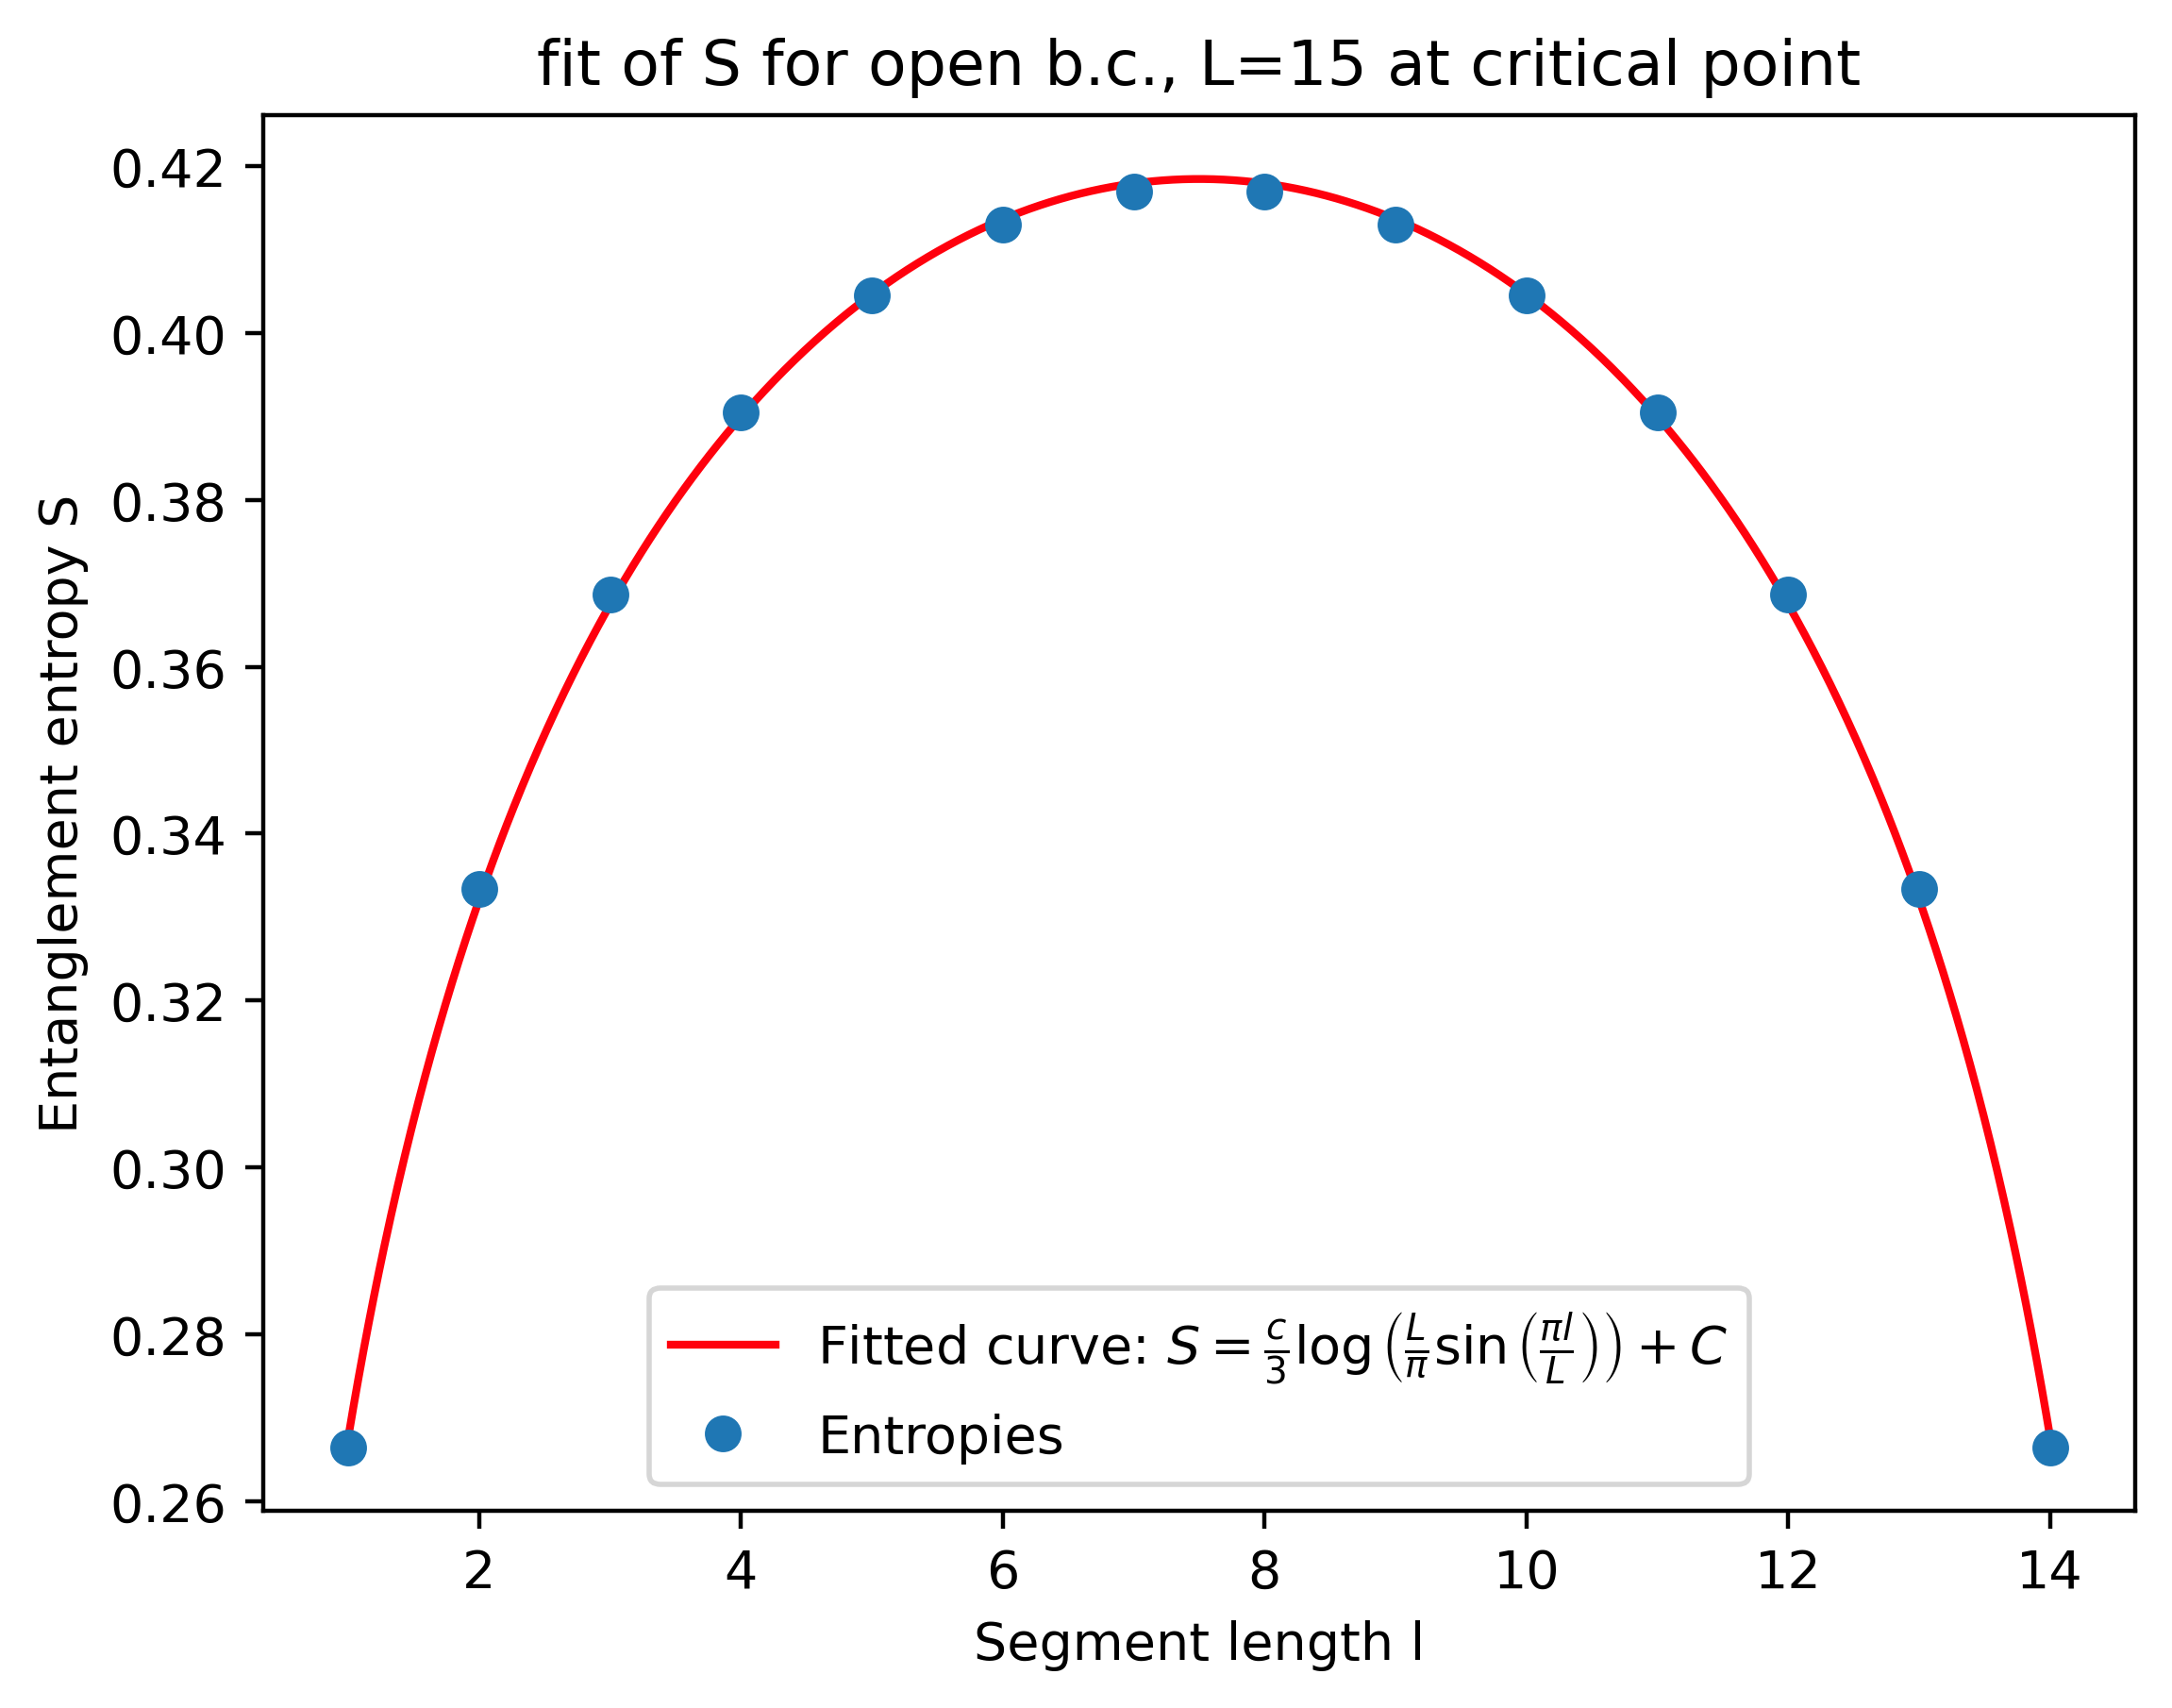

In [42]:
lcont = np.linspace(1, 14, 1000)
Econt = fitfunc(lcont, *params)

plt.plot(lcont, Econt, color='xkcd:bright red', label=r'Fitted curve: $S = \frac{{c}}{3} \log\left(\frac{{L}}{{\pi}} \sin\left(\frac{{\pi l}}{{L}}\right)\right) + {C}$')
plt.plot(ls, entropies, 'o', label='Entropies')


plt.xlabel('Segment length l')
plt.ylabel('Entanglement entropy S')
plt.title(f'fit of S for open b.c., L={L} at critical point')
plt.legend()
plt.savefig(os.path.join(directory, 'openfitE.png'), dpi =400)
plt.show()

In [16]:
def high_entropy(l, L, J, h, periodic):
    
    H = sparseH(L, J, h, periodic)
    
    vec = scipy.sparse.linalg.eigsh(H, k=1, which='LA')[1]
    
    psi_matrix = vec.reshape((2**l, 2**(L-l)))
    u, s, vh = np.linalg.svd(psi_matrix, compute_uv=True)
    lambdas = s**2
    S = -np.sum(lambdas * np.log(lambdas))

    return S

In [17]:
print(high_entropy(3, 10, 1, 0.4, True))

0.6952482724959438


Computing for L=13: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.02it/s]


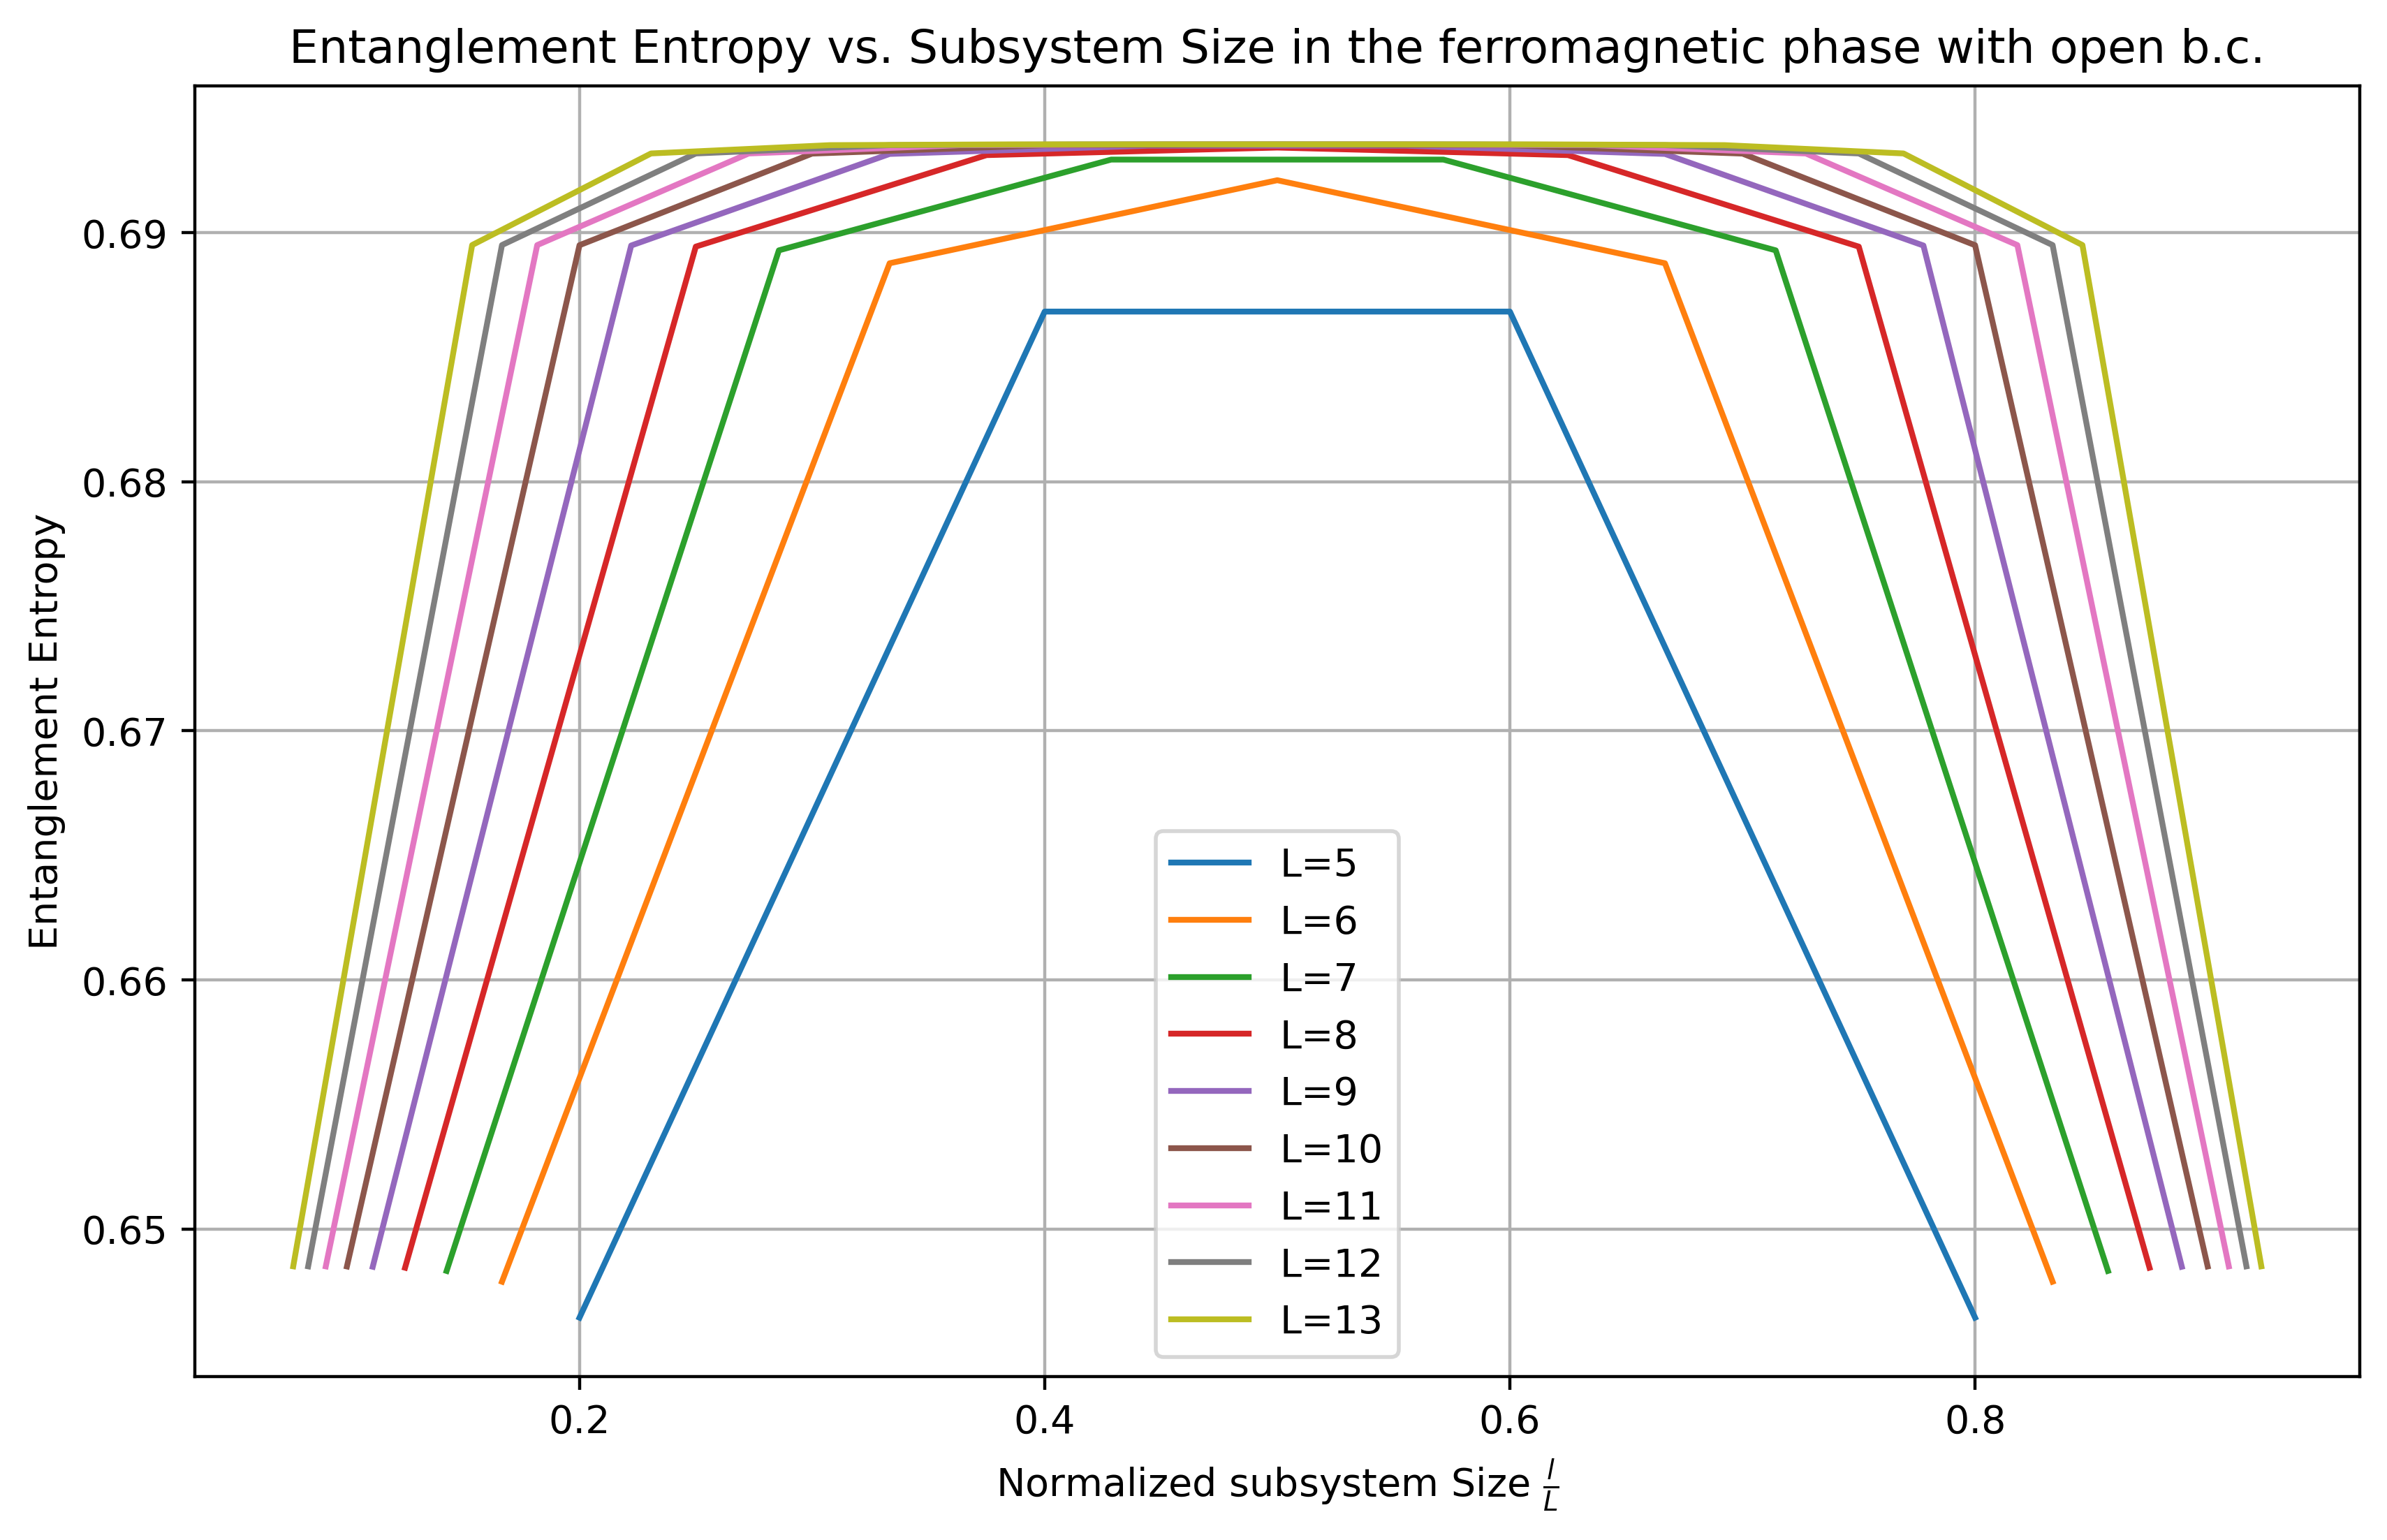

In [31]:
def compute_entropies(L_values, h, periodic):
    results = {}
    for L in L_values:
        ls = range(1, L)
        Entropies = []
        for l in tqdm(ls, desc=f'Computing for L={L}'):
            entropy = high_entropy(l, L, 1, h, periodic)
            Entropies.append(entropy)
        results[L] = Entropies
    return results

def plot_results(results):
    plt.figure(figsize=(10, 6))
    for L, entropies in results.items():
        plt.plot(range(1, L)/np.array(L), entropies, label=f'L={L}')
    plt.xlabel(r'Normalized subsystem Size $\frac{l}{L}$')
    plt.ylabel('Entanglement Entropy')
    plt.title('Entanglement Entropy vs. Subsystem Size in the ferromagnetic phase with open b.c.')
    plt.legend()
    plt.grid(True)

L_values = [5, 6, 7, 8, 9, 10, 11, 12, 13]
h = 0.3
periodic = False

entropies = compute_entropies(L_values, h, periodic)
plot_results(entropies)
plt.savefig(os.path.join(directory, 'ferro-openhighest.png'), dpi =400)
plt.show()


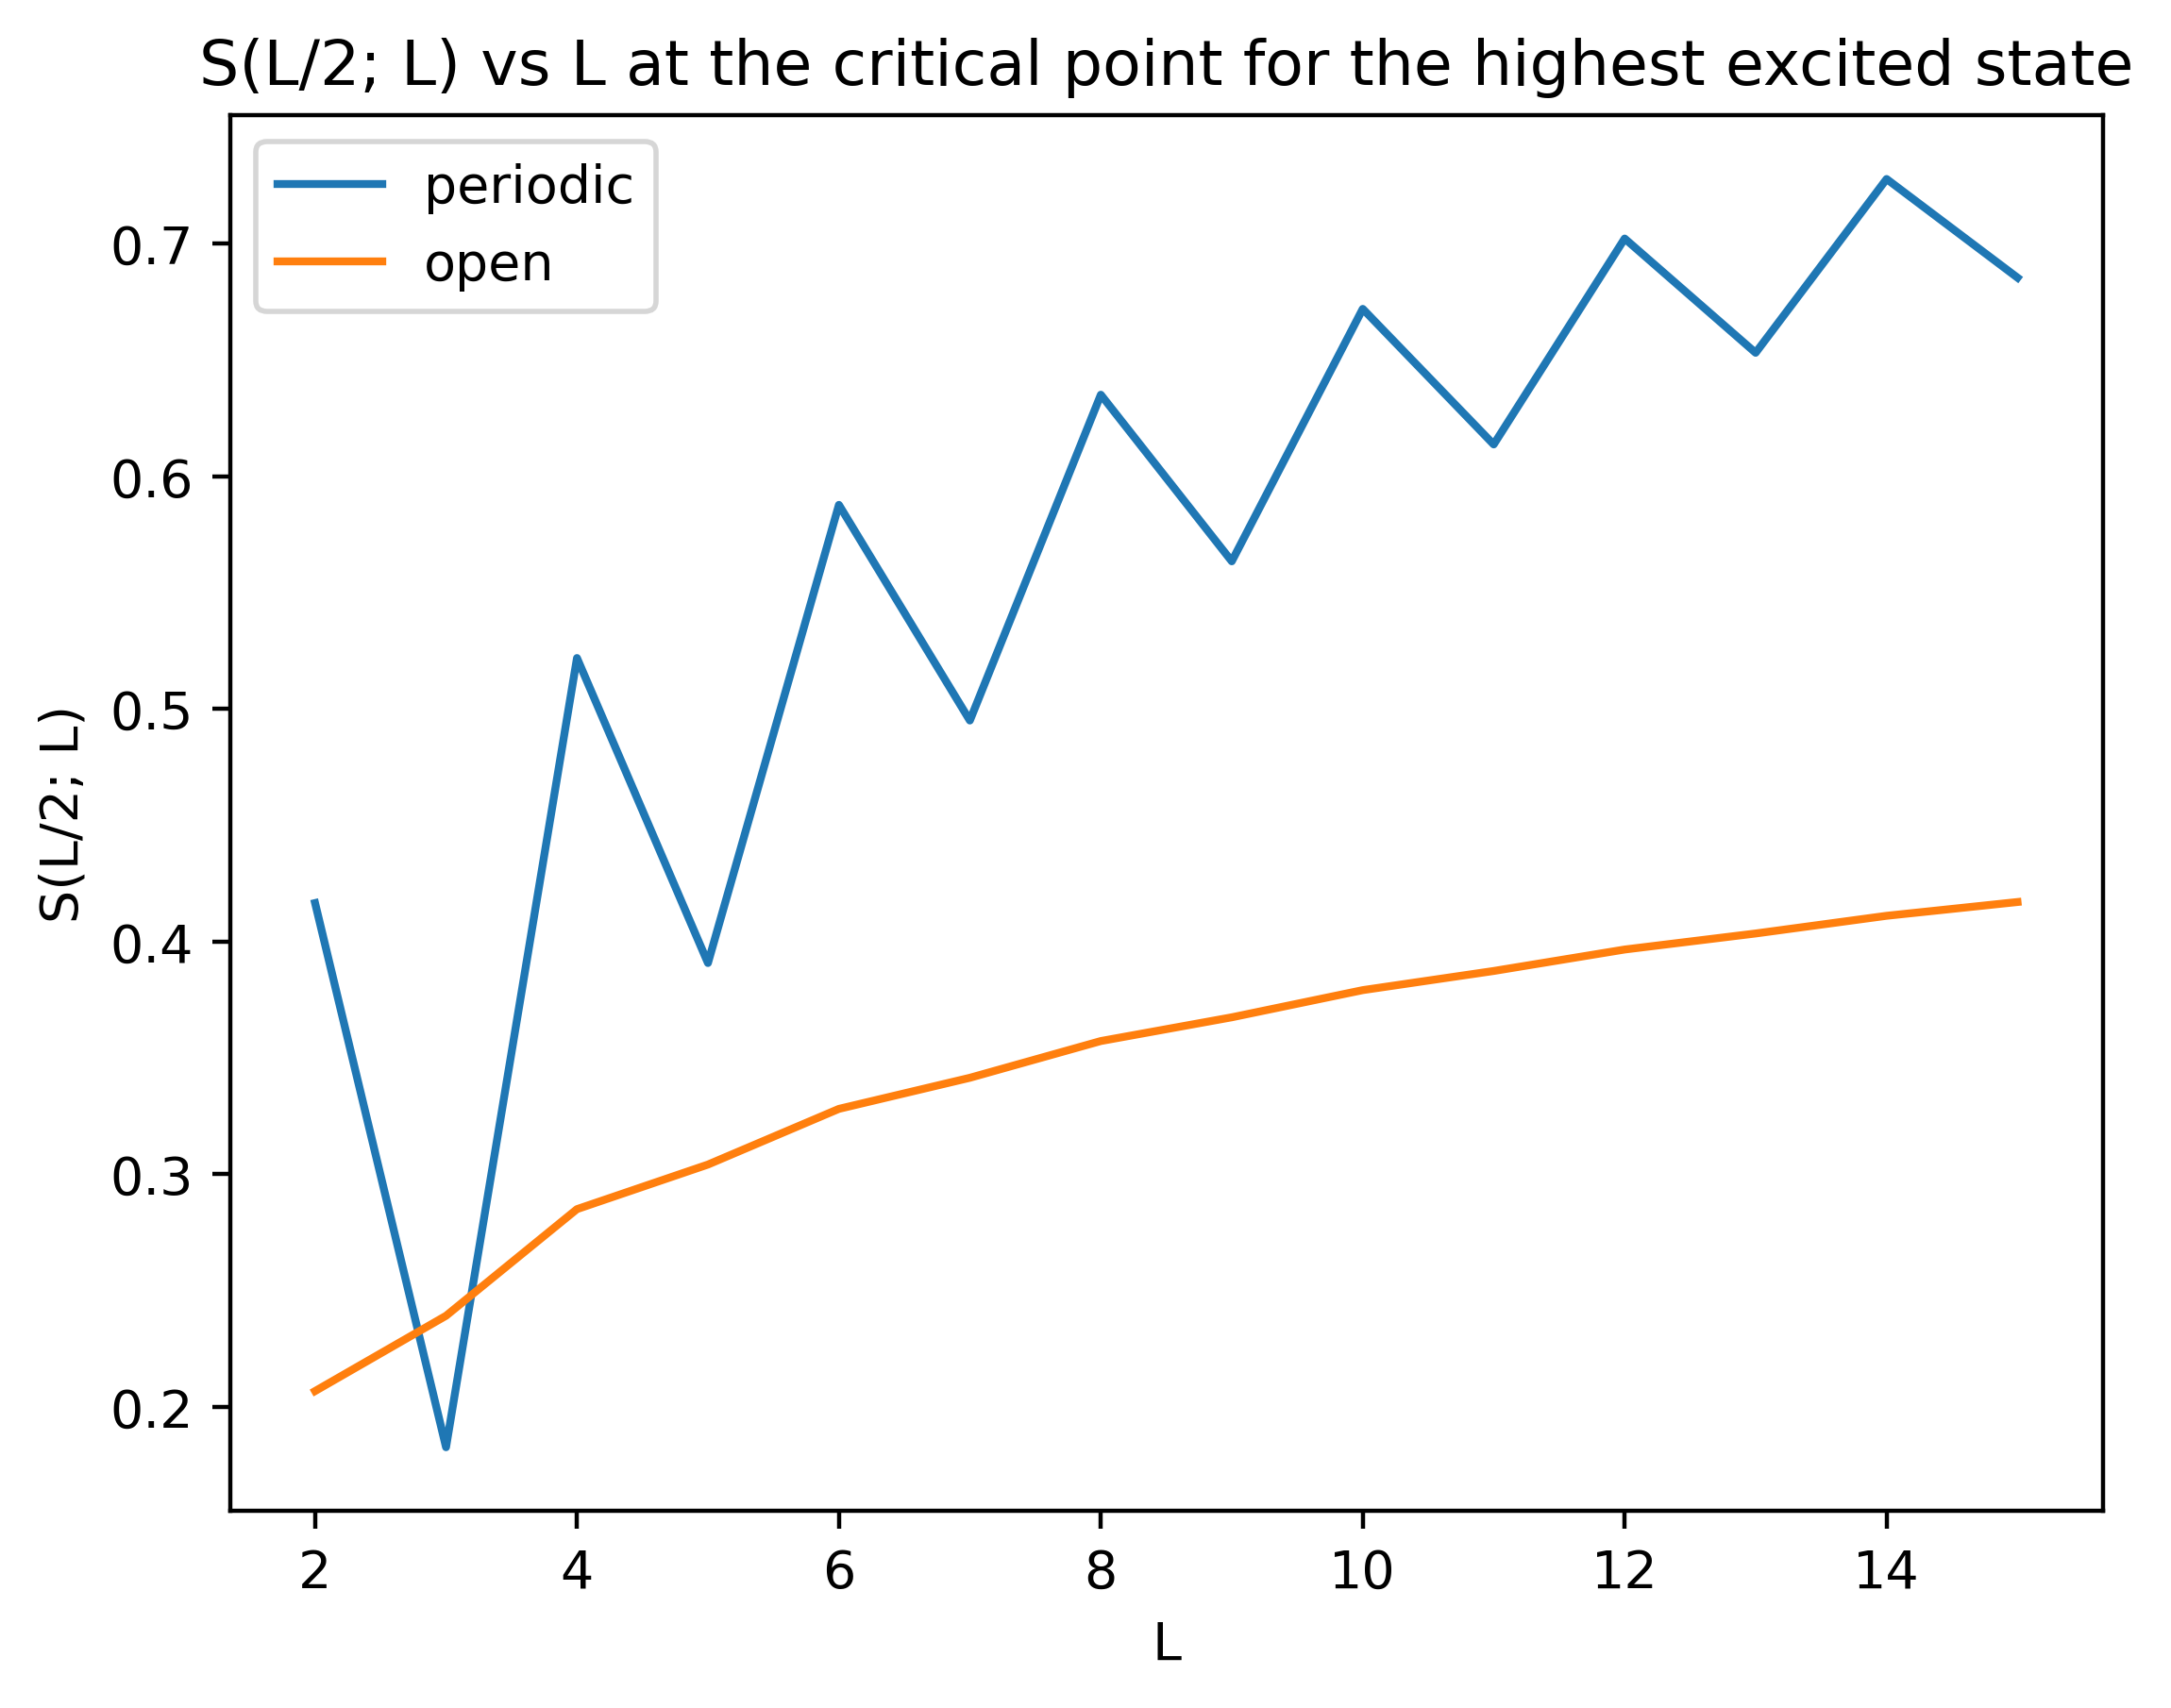

In [34]:
L_values = range(2, 16)
h = 1


Eper=[]
Eopen=[]

for L in L_values:
    if L%2 == 0:
        Eper.append(high_entropy(L//2, L, 1, h, True))
        Eopen.append(high_entropy(L//2, L, 1, h, False))
    else:
        Eper.append(high_entropy(L//2+1, L, 1, h, True))
        Eopen.append(high_entropy(L//2+1, L, 1, h, False))
        
plt.plot(L_values, Eper, label='periodic')
plt.plot(L_values, Eopen, label='open')
plt.xlabel('L')
plt.ylabel('S(L/2; L)')
plt.title('S(L/2; L) vs L at the critical point for the highest excited state')

plt.legend()
plt.savefig(os.path.join(directory, 'criticalSL2.png'), dpi =400)
plt.show()

In [52]:
L = 14
J = 1
h = 1
periodic = True
ls = np.array(range(1, L))
entropies=[]

for l in ls:
    entropy=high_entropy(l, L, J, h, periodic)
    entropies.append(entropy)

In [53]:
def fitfunc(l, c, C):
    return ((c/3) * np.log((L/np.pi) * np.sin(np.pi*(l/L)))) + C

params, covariance = scipy.optimize.curve_fit(fitfunc, ls, entropies)

c, C = params
print('c: ', c)
print('C: ', C)

c:  0.5083262773694218
C:  0.4751969950445797


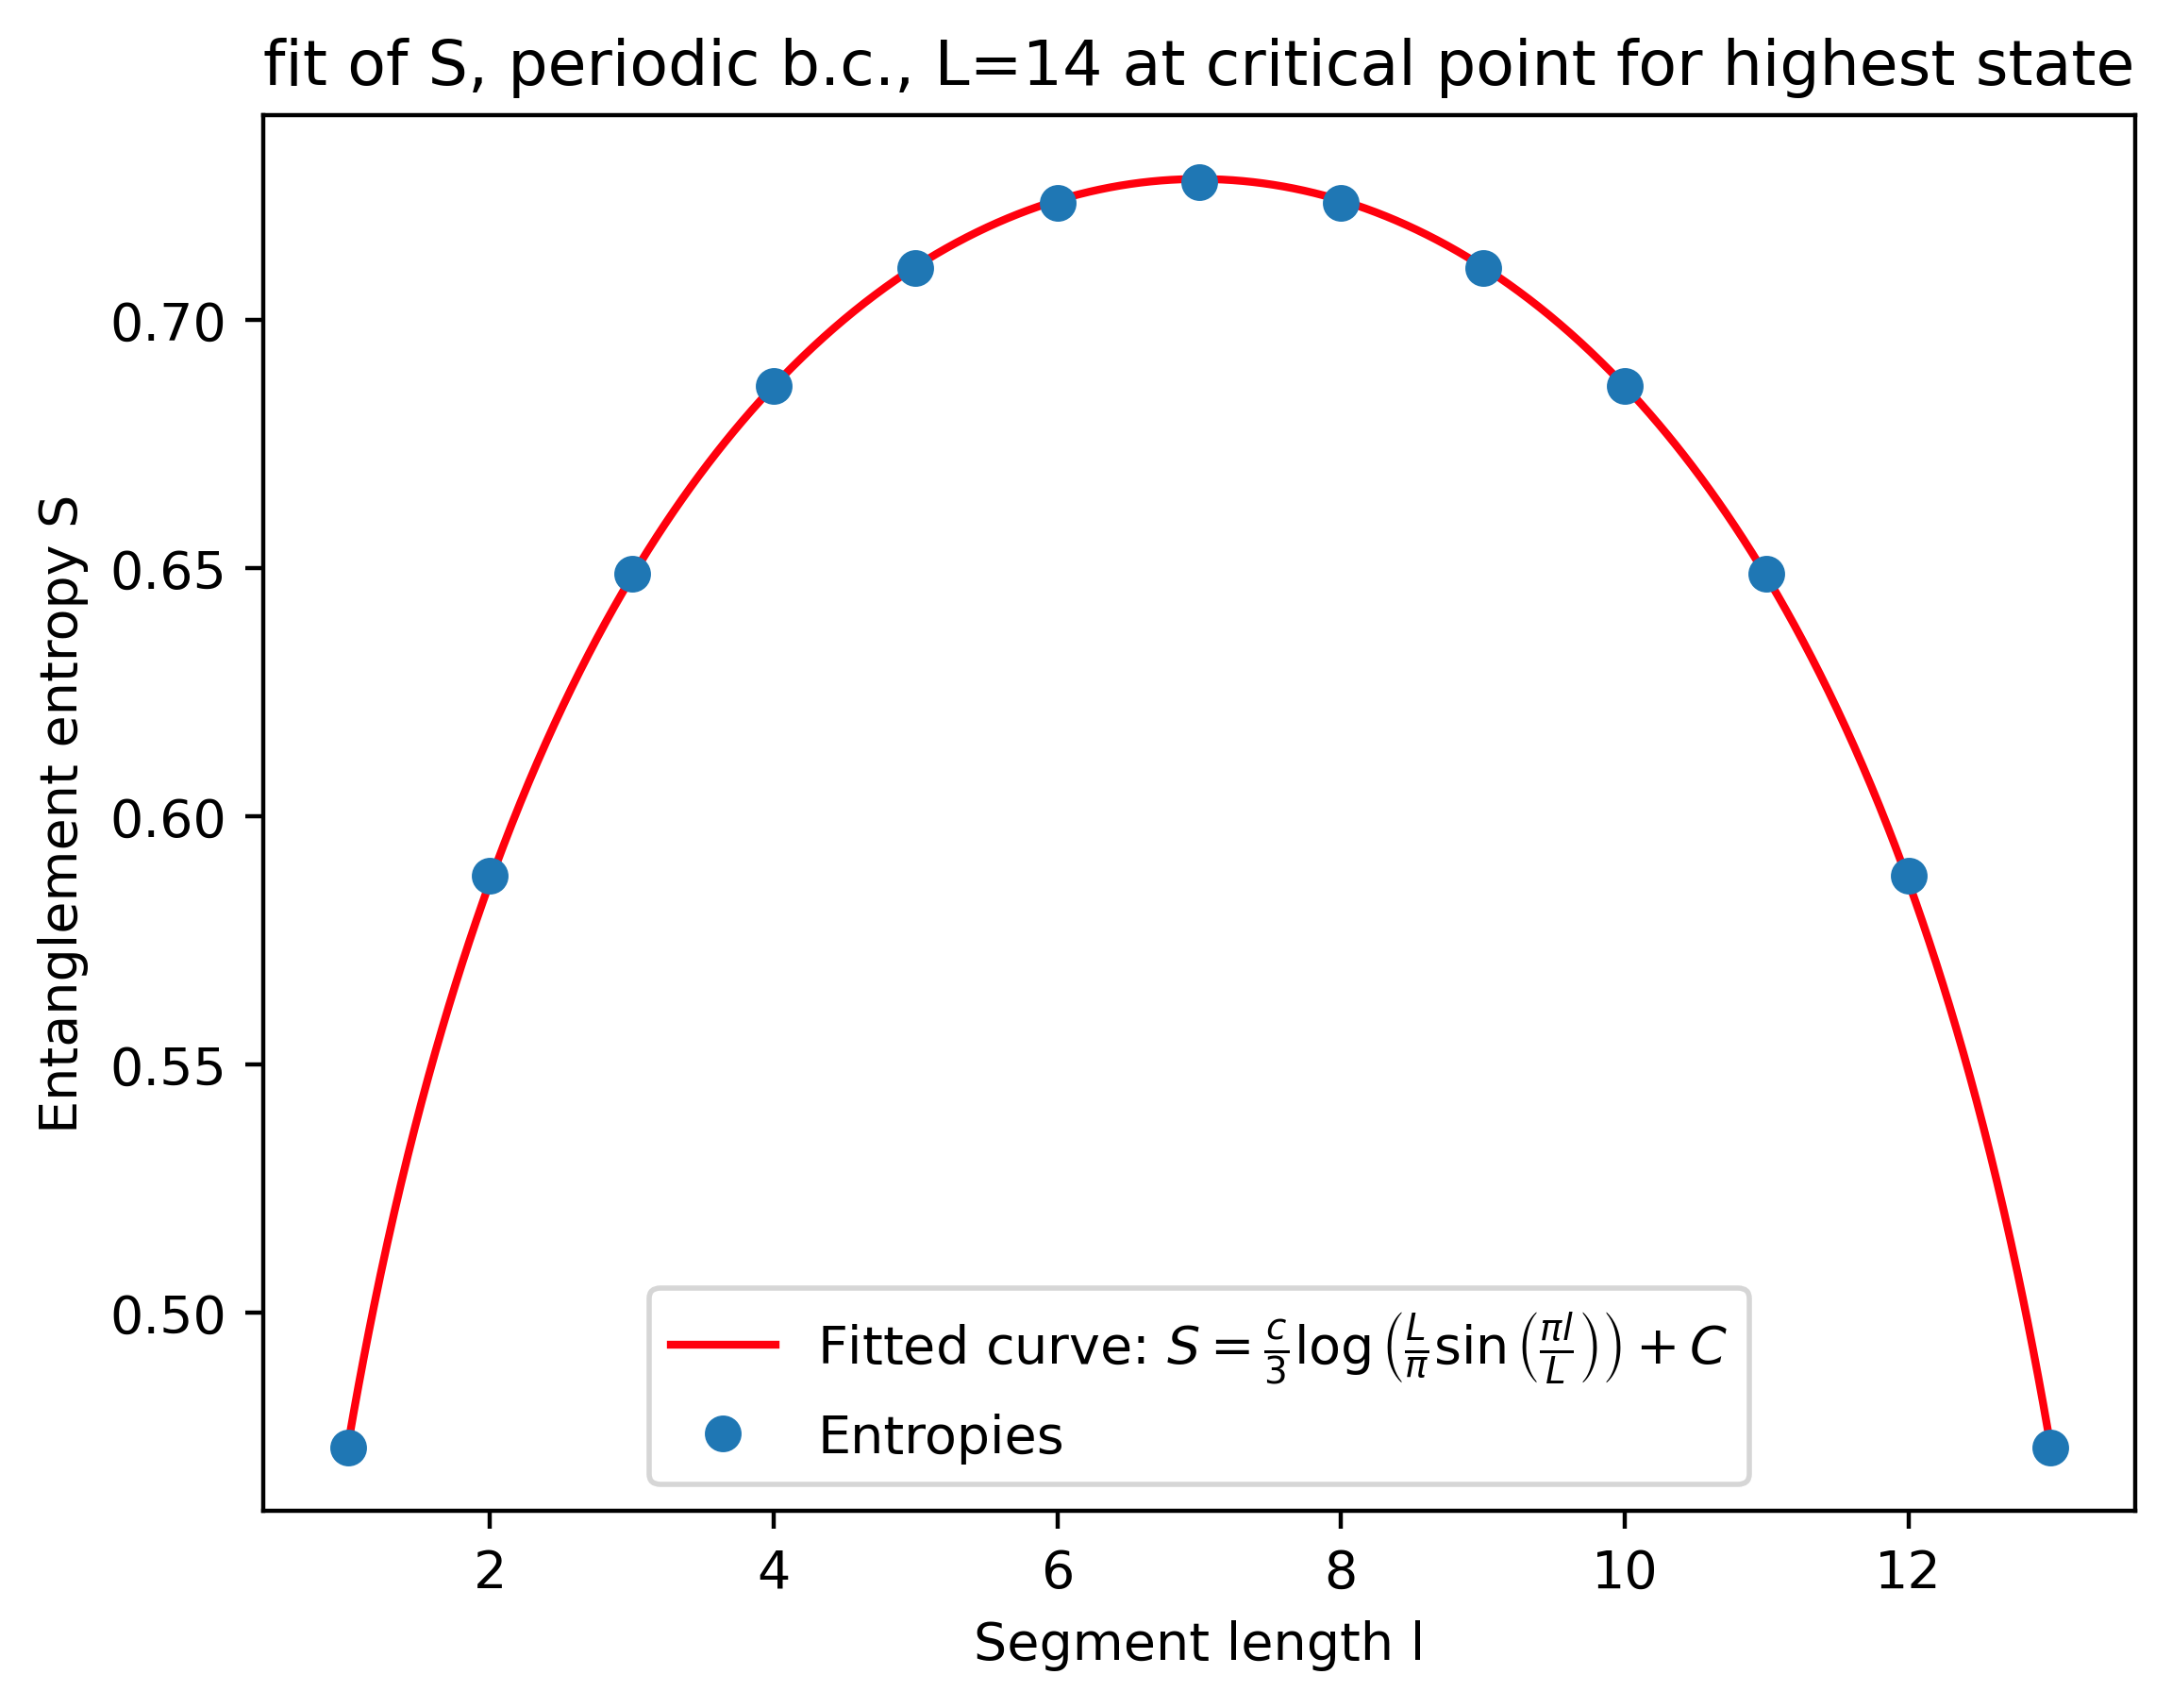

In [55]:
lcont = np.linspace(1, 13, 1000)
Econt = fitfunc(lcont, *params)

plt.plot(lcont, Econt, color='xkcd:bright red', label=r'Fitted curve: $S = \frac{{c}}{3} \log\left(\frac{{L}}{{\pi}} \sin\left(\frac{{\pi l}}{{L}}\right)\right) + {C}$')
plt.plot(ls, entropies, 'o', label='Entropies')


plt.xlabel('Segment length l')
plt.ylabel('Entanglement entropy S')
plt.title(f'fit of S, periodic b.c., L={L} at critical point for highest state')
plt.legend()
plt.savefig(os.path.join(directory, 'periodicfitEhighestno2.png'), dpi = 400)
plt.show()